In [35]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import masking
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import json


In [37]:

# Load the data
participants = pd.read_csv(os.path.join(data_dir, "participants.tsv"), sep='\t')

# Display basic summary of the dataframe
participants.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   participant_id     38 non-null     object 
 1   birthdate_shifted  38 non-null     object 
 2   sex                38 non-null     int64  
 3   adhd               38 non-null     int64  
 4   handedness         37 non-null     float64
 5   a_date             38 non-null     object 
 6   b_date             27 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 2.2+ KB


In [41]:
participants.head()

,participant_id,birthdate_shifted,sex,adhd,handedness,a_date,b_date
0,sub-213,1779-05-21,2,0,80.0,1800-05-13,1801-03-08
1,sub-214,1776-11-06,2,0,95.0,1800-05-15,NaN
2,sub-218,1789-07-14,1,0,-90.0,1800-08-20,1800-09-10
3,sub-219,1790-02-14,1,1,90.0,1801-01-30,1801-02-06
4,sub-220,1789-10-18,1,0,90.0,1801-04-20,1801-08-24


In [43]:
adhd_counts = participants['adhd'].value_counts()

print(adhd_counts)

adhd
0    26
1    12
Name: count, dtype: int64


In [21]:

def inspect_bold_file(bold_file_path):
    # Check if the file exists
    if not os.path.exists(bold_file_path):
        print(f"BOLD file does not exist at {bold_file_path}")
        return
    
    # If the file is a .gz compressed file
    if bold_file_path.endswith('.gz'):
        with gzip.open(bold_file_path, 'rb') as f:
            # Write the decompressed content to a temporary file (e.g., .nii)
            temp_nifti_path = bold_file_path[:-3]  # Remove the '.gz' extension
            with open(temp_nifti_path, 'wb') as temp_f:
                temp_f.write(f.read())
            
            # Load the decompressed NIfTI file using nibabel
            bold_img = nib.load(temp_nifti_path)
            print(f"Shape of the data: {bold_img.shape}")
            print(f"Header information:\n{bold_img.header}")
            print(f"Data array shape: {bold_img.get_fdata().shape}")
            os.remove(temp_nifti_path)
    else:
        print(f"Inspecting BOLD file: {bold_file_path}")
        bold_img = nib.load(bold_file_path)
        print(f"Shape of the data: {bold_img.shape}")
        print(f"Header information:\n{bold_img.header}")
        print(f"Data array shape: {bold_img.get_fdata().shape}")





In [55]:


def inspect_event_file(event_file_path):
  
    event_df = pd.read_csv(event_file_path, sep="\t")
    
    # Print the columns of the DataFrame
    print("\nColumns in the event file:")
    print(event_df.columns)
    
    # Get some basic statistics about the data (if numeric columns exist)
    print("\nSummary statistics of numeric columns:")
    print(event_df.describe())
    
    # Check for any missing values
    print("\nMissing values in the event file:")
    print(event_df.isnull().sum())




In [57]:
event_file_path = r"C:\Users\ASUS\Documents\data\sub-213\func\sub-213_task-Conj1Inh_acq-a_events.tsv"  # Replace with your event file path

event_df = pd.read_csv(event_file_path, sep="\t")
    
event_df.head()
    

,onset,duration,block,block_type_intended,block_type_performed,response_time_avg,correct_total,errors_total,false-no_go,false-go,NR,comments
0,0.00,38.69,1,go,go,0.3461,18.0,0,NaN,NaN,NaN,NaN
1,38.69,38.69,2,no-go,no-go,0.4628,18.0,0,NaN,NaN,NaN,NaN
2,77.38,38.69,3,go,go,0.3092,18.0,0,NaN,NaN,NaN,NaN
3,116.07,38.69,4,no-go,no-go,0.4922,17.0,1,NaN,1.0,NaN,NaN
4,154.76,38.69,5,go,go,0.3386,18.0,0,NaN,NaN,NaN,NaN


In [59]:
# Example 
event_file_path = r"C:\Users\ASUS\Documents\data\sub-213\func\sub-213_task-Conj1Inh_acq-a_events.tsv"  # Replace with your event file path

# Inspect the event file
inspect_event_file(event_file_path)



Columns in the event file:
Index(['onset', 'duration', 'block', 'block_type_intended',
       'block_type_performed', 'response_time_avg', 'correct_total',
       'errors_total', 'false-no_go', 'false-go', 'NR', 'comments'],
      dtype='object')

Summary statistics of numeric columns:
            onset  duration      block  response_time_avg  correct_total  \
count   12.000000     12.00  12.000000          12.000000      12.000000   
mean   212.795000     38.69   6.500000           0.413700      17.833333   
std    139.498779      0.00   3.605551           0.078819       0.389249   
min      0.000000     38.69   1.000000           0.309200      17.000000   
25%    106.397500     38.69   3.750000           0.338550      18.000000   
50%    212.795000     38.69   6.500000           0.418700      18.000000   
75%    319.192500     38.69   9.250000           0.488225      18.000000   
max    425.590000     38.69  12.000000           0.519900      18.000000   

       errors_total  false-

In [80]:
#Example
bold_file_path = r"C:\Users\ASUS\Documents\data\sub-213\func\sub-213_task-Conj1Inh_acq-a_bold.nii.gz"  # Replace with your BOLD file path (or .nii if not gzipped)

# Inspect the BOLD file 
inspect_bold_file(bold_file_path)

Shape of the data: (64, 64, 32, 156)
Header information:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  64  64  32 156   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.      3.4375  3.4375  4.      3.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'6.0.1'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 1

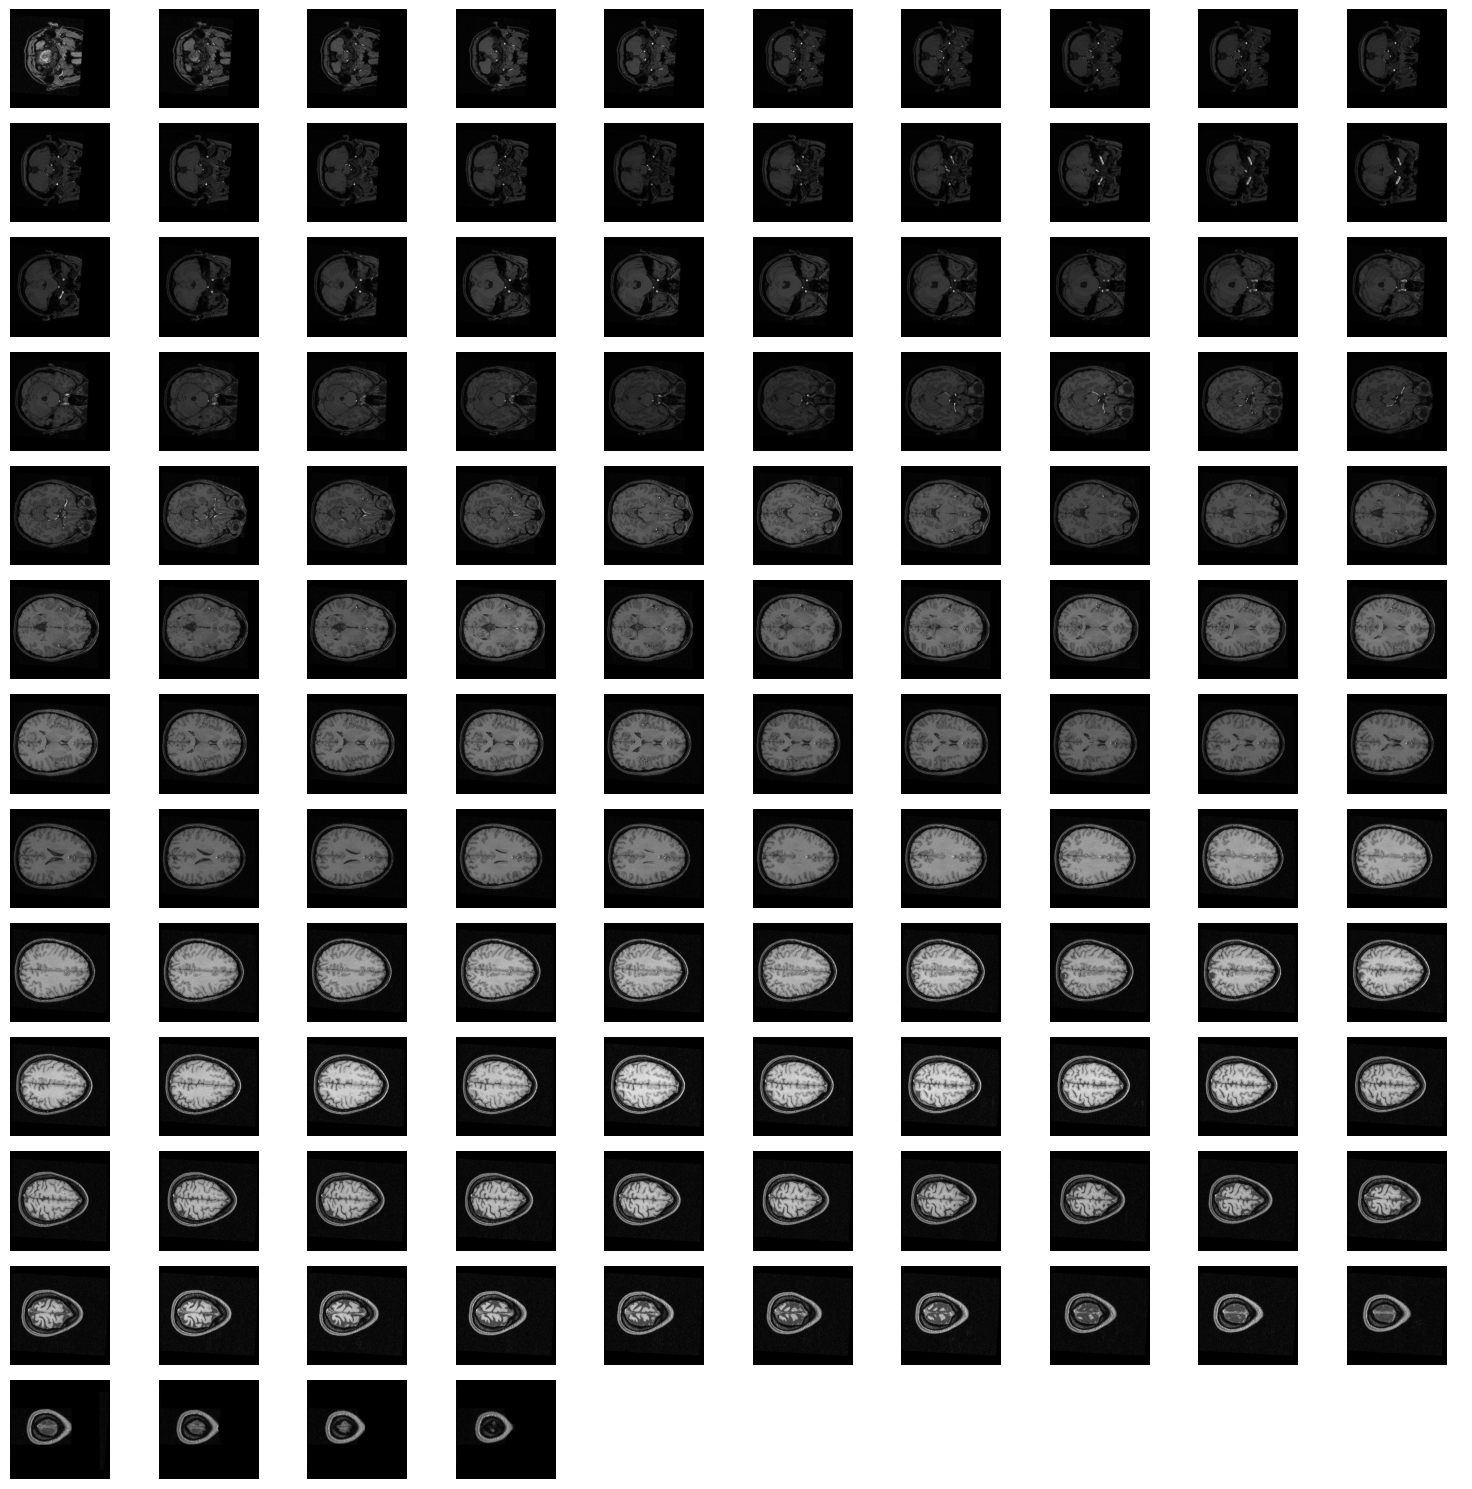

In [63]:
#Example
# Load the anatomical T1w file
anat_file = "./sub-213/anat/sub-213_acq-a_T1w.nii.gz"
anat_img = nib.load(anat_file)
anat_data = anat_img.get_fdata()

# Define the number of columns and rows for the grid
num_slices = anat_data.shape[2]  # Number of slices in the z-axis (third dimension)
cols = 10  # You can adjust this based on how many slices you want per row
rows = int(np.ceil(num_slices / cols))  # Compute number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten axes array to make it easier to index

# Loop through all slices and display them in the grid
for i in range(num_slices):
    ax = axes[i]  
    ax.imshow(anat_data[:, :, i], cmap="gray")  # Display the i-th slice
    ax.axis("off") 


for j in range(num_slices, len(axes)):
    axes[j].axis("off")  #to look better

plt.tight_layout()
plt.show()


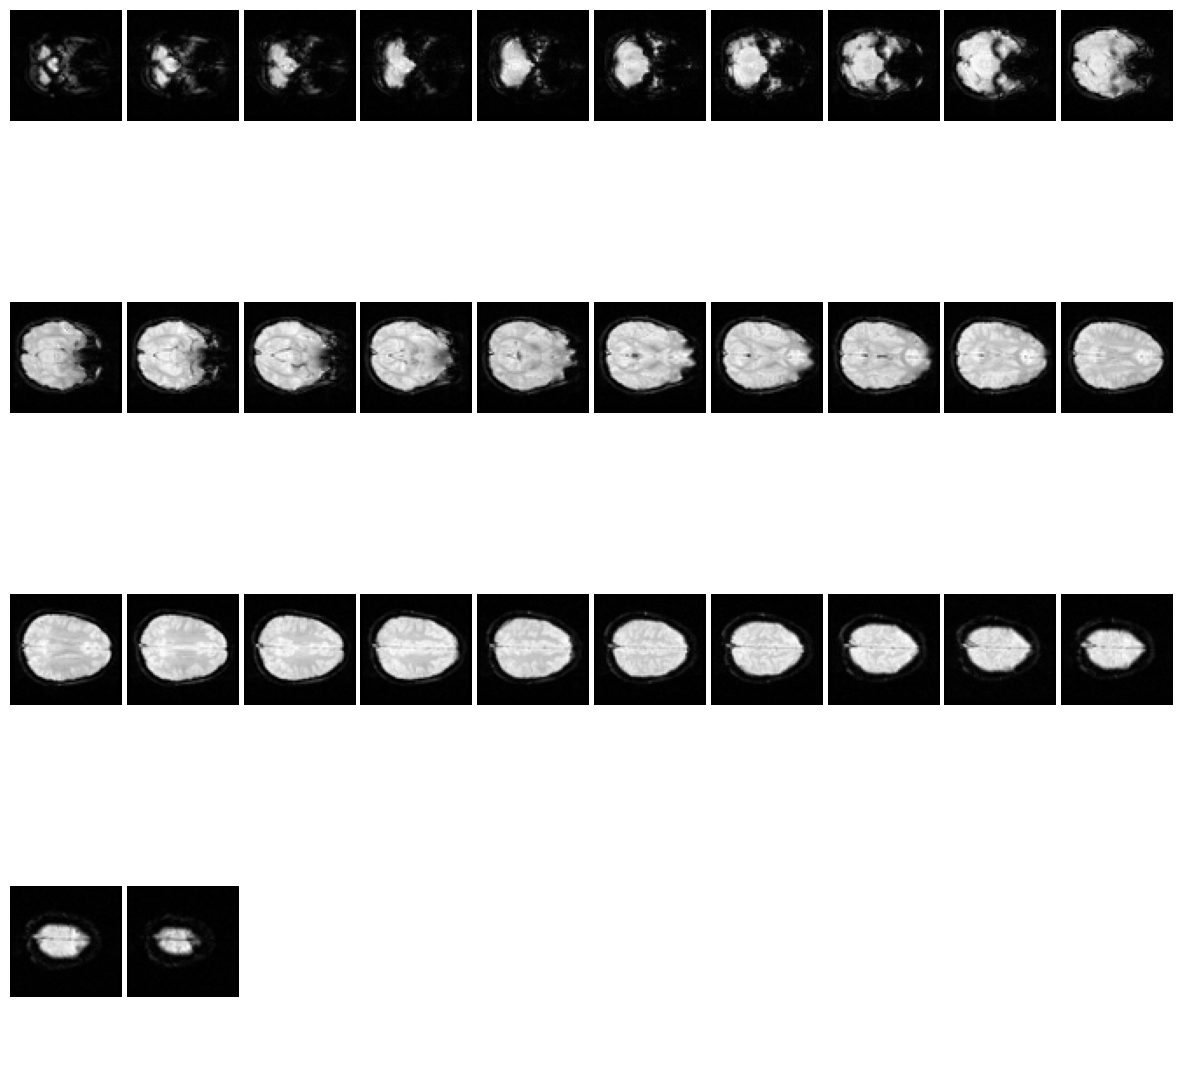

In [65]:
#example
# Load the functional BOLD file
func_file = "./sub-213/func/sub-213_task-Conj19Sel_acq-a_bold.nii.gz"
func_img = nib.load(func_file)
func_data = func_img.get_fdata()


num_slices = func_data.shape[2]  # Number of slices in the 3rd dimension
cols = 10 
rows = int(np.ceil(num_slices / cols)) 


fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten() 

# Loop through all slices and display them in the grid for the first timepoint
for i in range(num_slices):
    ax = axes[i] 
    ax.imshow(func_data[:, :, i, 0], cmap="gray")  # Display the i-th slice, first timepoint
    
    ax.axis("off")  


for j in range(num_slices, len(axes)):
    axes[j].axis("off")

# Adjust layout with less gap between images
plt.subplots_adjust(wspace=0.05, hspace=0.05) 
plt.show()


In [67]:

# Define paths to your dataset
data_dir = r"C:\Users\ASUS\Documents\data"  # Correct path to your data directory

# List of subject IDs (based on your directory list)
subject_ids = ['sub-213', 'sub-214', 'sub-218', 'sub-219', 'sub-220', 'sub-221', 'sub-222', 'sub-223', 'sub-224', 
               'sub-225', 'sub-226', 'sub-228', 'sub-229', 'sub-230', 'sub-231', 'sub-232', 'sub-233', 'sub-234', 
               'sub-235', 'sub-236', 'sub-237', 'sub-238', 'sub-240', 'sub-241', 'sub-242', 'sub-245', 'sub-246', 
               'sub-248', 'sub-250', 'sub-251', 'sub-253', 'sub-254', 'sub-256', 'sub-258', 'sub-259', 'sub-260', 
               'sub-262', 'sub-268']



In [19]:

X_list = []
y_list = []

# Load participants data (for'ADHD' label)
participants = pd.read_csv(os.path.join(data_dir, "participants.tsv"), sep='\t')

# Loop over all subjects and extract features
for sub_id in subject_ids:
    subject_dir = os.path.join(data_dir, sub_id)
    
    # Explore the 'func' folder for BOLD and task-related files 
    func_dir = os.path.join(subject_dir, "func")
    
    # Find the BOLD image and corresponding event files
    bold_file = None
    event_file = None

    for file in os.listdir(func_dir):
        if file.endswith("_bold.nii.gz"):
            bold_file = os.path.join(func_dir, file)
        elif "_task-" in file and file.endswith("_events.tsv"):
             event_file = os.path.join(func_dir, file)

    # Skip this subject if no BOLD or event files are found
    if not bold_file or not event_file:
        print(f"Missing BOLD or event file for {sub_id}")
        continue
    
    # Load the BOLD image
    bold_img = nib.load(bold_file)
    
    
    masked_data = bold_img.get_fdata()  # Get the raw fMRI data 
    
    # Extract the mean activation in the masked brain regions across time (this is a simplified approach)
    mean_activation = masked_data.mean(axis=(0, 1, 2))  # Mean activation per time point (over the spatial dimensions)
    
    # Load the task event data from the TSV file
    event_data = pd.read_csv(event_file, sep='\t')
    
    
    # For example, count the number of 'go' vs. 'no-go' events in the task
    go_count = event_data[event_data['block_type_intended'] == 'go'].shape[0]
    no_go_count = event_data[event_data['block_type_intended'] == 'no-go'].shape[0]
    
    # to train
    avg_response_time = event_data['response_time_avg'].mean() if not event_data['response_time_avg'].isnull().all() else 0
    
    # Combine brain activity features with task performance features
    task_features = np.array([go_count, no_go_count, avg_response_time])
    combined_features = np.concatenate([mean_activation, task_features])
    
    X_list.append(combined_features)
    
    # Get ADHD label for the current subject 
    y_list.append(participants.loc[participants['participant_id'] == sub_id, 'adhd'].values[0])

# Convert the feature list and label list to numpy arrays
X = np.array(X_list)
y = np.array(y_list)

# Standardize the features (important for some ML models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)



# Random Forest

Accuracy: 0.6250
Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.00      0.00      0.00         3

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8



C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


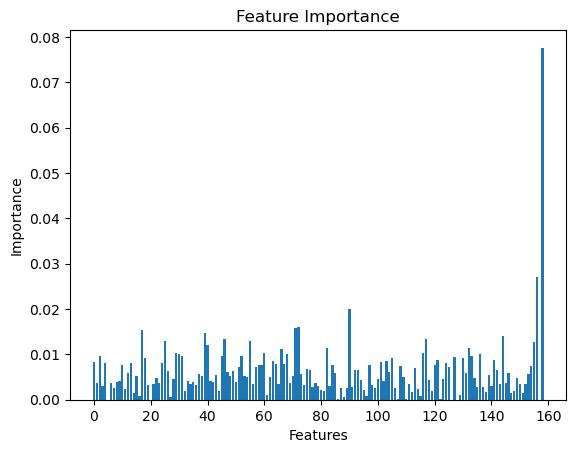

In [122]:

# Initialize a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')


# Train the model
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize feature importance
importances = clf.feature_importances_
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

# CNN

In [71]:

# Initialize lists to store features (X) and labels (y)
X_list = []
y_list = []

# Load participants data (assuming 'ADHD' label exists)
participants = pd.read_csv(os.path.join(data_dir, "participants.tsv"), sep='\t')

# Inside the loop where you are processing each subject
for sub_id in subject_ids:
    subject_dir = os.path.join(data_dir, sub_id)
    func_dir = os.path.join(subject_dir, "func")
    
    bold_file = None
    event_file = None

    for file in os.listdir(func_dir):
        if file.endswith("_bold.nii.gz"):
            bold_file = os.path.join(func_dir, file)
        elif "_task-" in file and file.endswith("_events.tsv"):
            event_file = os.path.join(func_dir, file)

    if not bold_file or not event_file:
        print(f"Missing BOLD or event file for {sub_id}")
        continue
    
    bold_img = nib.load(bold_file)
    masked_data = bold_img.get_fdata()  # Raw fMRI data

    # Take only the first timepoint (or reshape as needed)
    masked_data_reshaped = masked_data[..., 0]  # Keep just the first time point
    masked_data_reshaped = masked_data_reshaped[..., np.newaxis]  # Add channel axis

    # Collect task-related features (from the event file)
    event_data = pd.read_csv(event_file, sep='\t')
    go_count = event_data[event_data['block_type_intended'] == 'go'].shape[0]
    no_go_count = event_data[event_data['block_type_intended'] == 'no-go'].shape[0]
    avg_response_time = event_data['response_time_avg'].mean() if not event_data['response_time_avg'].isnull().all() else 0
    task_features = np.array([go_count, no_go_count, avg_response_time])

    # Append reshaped data and labels
    X_list.append(masked_data_reshaped)
    y_list.append(participants.loc[participants['participant_id'] == sub_id, 'adhd'].values[0])

# Convert to numpy arrays
X = np.array(X_list)
y = np.array(y_list)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the data (optional)
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)



In [72]:

# Build the CNN model
model = Sequential()

# Add a 3D convolutional layer
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(64, 64, 32, 1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Add another convolutional layer
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the output of the last convolution layer
model.add(Flatten())

# Add fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [73]:

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - accuracy: 0.4775 - loss: 0.9040 - val_accuracy: 0.6250 - val_loss: 0.6570
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.5692 - loss: 0.6790 - val_accuracy: 0.6250 - val_loss: 0.6670
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.7017 - loss: 0.6493 - val_accuracy: 0.6250 - val_loss: 0.6427
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.6258 - loss: 0.6259 - val_accuracy: 0.6250 - val_loss: 0.7181
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.7383 - loss: 0.5924 - val_accuracy: 0.6250 - val_loss: 0.7192
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.7342 - loss: 0.5664 - val_accuracy: 0.6250 - val_loss: 0.6091
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.6833 - loss: 0.5994 - val_accuracy: 0.6250 - val_loss: 0.6097
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.7558 - loss: 0.6091 - val_accuracy: 0.6250 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.33      0.50         3

    accuracy                           0.75         8
   macro avg       0.86      0.67      0.67         8
weighted avg       0.82      0.75      0.71         8

Accuracy: 0.75


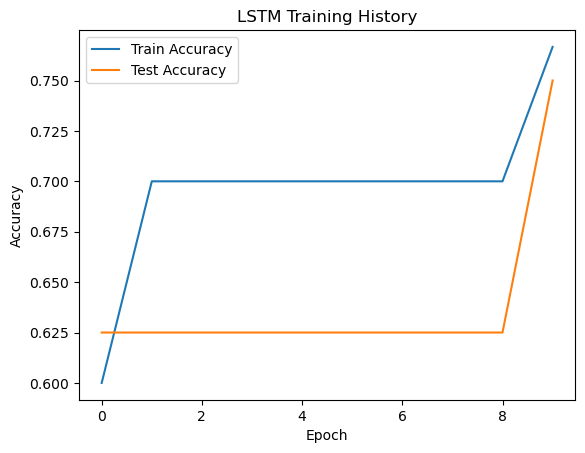

In [15]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Step 6: Plot training history (optional)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# LSTM


In [89]:
# Initialize lists to store features (X) and labels (y)
X_list = []
y_list = []

# Load participants data (assuming 'ADHD' label exists)
participants = pd.read_csv(os.path.join(data_dir, "participants.tsv"), sep='\t')

# Loop over all subjects and extract features
for sub_id in subject_ids:
    subject_dir = os.path.join(data_dir, sub_id)
    func_dir = os.path.join(subject_dir, "func")
    
    # Find the BOLD image and corresponding event files
    bold_file = None
    event_file = None

    for file in os.listdir(func_dir):
        if file.endswith("_bold.nii.gz"):
            bold_file = os.path.join(func_dir, file)
        elif "_task-" in file and file.endswith("_events.tsv"):
             event_file = os.path.join(func_dir, file)

    # Skip subject if files are missing
    if not bold_file or not event_file:
        print(f"Missing BOLD or event file for {sub_id}")
        continue
    
    # Load and extract data from the BOLD image
    bold_img = nib.load(bold_file)
    masked_data = bold_img.get_fdata()  # Raw fMRI data

    # Simplified feature extraction: mean activation across spatial dimensions
    mean_activation = masked_data.mean(axis=(0, 1, 2))
    
    # Load the task event data
    event_data = pd.read_csv(event_file, sep='\t')
    
    # Task-related features
    go_count = event_data[event_data['block_type_intended'] == 'go'].shape[0]
    no_go_count = event_data[event_data['block_type_intended'] == 'no-go'].shape[0]
    avg_response_time = event_data['response_time_avg'].mean() if not event_data['response_time_avg'].isnull().all() else 0
    
    # Combine features
    task_features = np.array([go_count, no_go_count, avg_response_time])
    combined_features = np.concatenate([mean_activation, task_features])
    X_list.append(combined_features)
    
    # Get ADHD label for the subject
    y_list.append(participants.loc[participants['participant_id'] == sub_id, 'adhd'].values[0])

# Convert the feature list and label list to numpy arrays
X = np.array(X_list)
y = np.array(y_list)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for LSTM input
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [90]:

model = Sequential()

# Add an LSTM layer
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))

# Add a Dense layer for output
model.add(Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=45, batch_size=8, validation_data=(X_test, y_test))


Epoch 1/45


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.4792 - loss: 0.7065 - val_accuracy: 0.8750 - val_loss: 0.6094
Epoch 2/45
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6633 - loss: 0.6452 - val_accuracy: 0.7500 - val_loss: 0.5859
Epoch 3/45
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6675 - loss: 0.6568 - val_accuracy: 0.7500 - val_loss: 0.5745
Epoch 4/45
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6842 - loss: 0.7063 - val_accuracy: 0.7500 - val_loss: 0.5618
Epoch 5/45
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6633 - loss: 0.6330 - val_accuracy: 0.7500 - val_loss: 0.5522
Epoch 6/45
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7092 - loss: 0.6080 - val_accuracy: 0.7500 - val_loss: 0.5435
Epoch 7/45
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7008 - loss: 0.6030 - val_accuracy: 0.7500 - val_loss: 0.5389
Epoch 8/45
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7550 - loss: 0.5694 - val_accuracy: 0.7500 - val_loss: 0.5282
Epoch 9/45

In [91]:

#Evaluate the model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels

# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8

Accuracy: 0.875


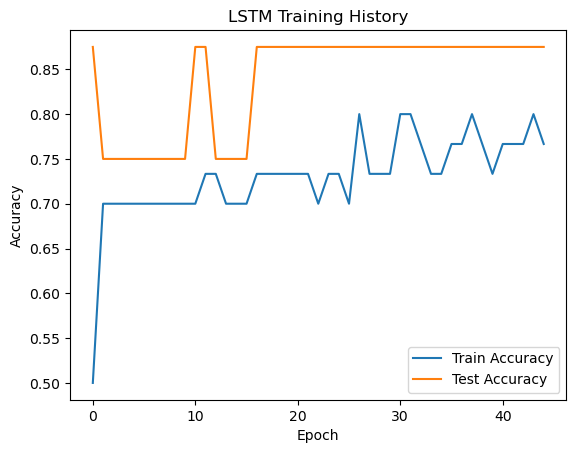

In [92]:
# Plot training history (optional)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
